In [1]:
from src.data_loader import DataLoader
from src.sales_processor import SalesProcessor
from src.feature_engineer import FeatureEngineer
from src.data_aggregator import DataAggregator
import pandas as pd


In [2]:
data_loader = DataLoader()
# data_dict = data_loader.load_all_data()
customer_master = data_loader.load_customer_master()
sales_data = data_loader.load_sales_data()

sales_processor = SalesProcessor(sales_data, customer_master)
sales_results = sales_processor.process_sales_data()

last_billed = sales_results['last_billed']
sales_journey = sales_results['sales_journey']
days_between_purchase = sales_results['days_between_purchase']


print(f"✅ Sales data processed successfully:")
print(f"   - Last Billed: {last_billed.shape}")
print(f"   - Sales Journey: {sales_journey.shape}")
print(f"   - Days Between Purchase: {days_between_purchase.shape}")


        

⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `tableau_delta_tables`
⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `sap_data`
⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `jkc`
⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `gold_layer`
📖 Reading table: `customer_master`...
✅ Successfully read data from `customer_master`.
📖 Reading table: `sales_data`...
✅ Successfully read data from `sales_data`.
Preparing sales data...
Calculating churn labels...
Calculating sales streaks...


/Users/sanyamjain/Desktop/work/dealer-churn-1/src/sales_processor.py:89: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  streak_info_df = full_sales.groupby('dealer_code').apply(self._get_max_streak_info).reset_index()


Calculating threshold dates...
Creating sales journey...
Calculating days between purchases...
✅ Sales data processed successfully:
   - Last Billed: (7791, 8)
   - Sales Journey: (4686430, 15)
   - Days Between Purchase: (7717, 2)


In [3]:
print("\n🔧 Step 3: Feature Engineering")
print("-" * 30)
feature_engineer = FeatureEngineer(sales_journey, customer_master, sales_processor.reference_date)

# Add dealership age
customer_master = feature_engineer.add_dealership_age()

# Create monthly sales features
monthly_sales = feature_engineer.create_monthly_sales_features()

# Create territory and club features
terrwise_monthly_sales, dealerclubwise_monthly_sales = feature_engineer.create_territory_and_club_features(monthly_sales)

# Merge territory and club features
monthly_sales = pd.merge(
    monthly_sales, 
    terrwise_monthly_sales, 
    on=['territory_code', 'period'], 
    how='left'
).merge(
    dealerclubwise_monthly_sales, 
    on=['dealer_club_category', 'period'], 
    how='left'
)


🔧 Step 3: Feature Engineering
------------------------------


In [4]:
sas_monthly_data = data_loader.load_sas_monthly_data()
# Process SAS data
sas_monthly_data = feature_engineer.process_sas_data(sas_monthly_data)

# Create rotation features
monthly_sales, terrwise_sas, dealerclub_wise_sas = feature_engineer.create_rotation_features(
    monthly_sales, sas_monthly_data
)

# Merge SAS features
monthly_sales = pd.merge(
    monthly_sales, 
    terrwise_sas, 
    on=['territory_code', 'period'], 
    how='left'
).merge(
    dealerclub_wise_sas, 
    on=['dealer_club_category', 'period'], 
    how='left'
)

📖 Reading table: `monthly_club_mapping`...
✅ Successfully read data from `monthly_club_mapping`.


In [5]:
credit_note_df = data_loader.load_credit_note_data()

📖 Reading table: `credit_note`...
✅ Successfully read data from `credit_note`.


In [6]:
movement_counts = feature_engineer.create_club_movement_features(sas_monthly_data)

outstanding_df = data_loader.load_outstanding_data()


📖 Reading table: `customer_financial`...
✅ Successfully read data from `customer_financial`.


In [7]:
# Process outstanding data
outstanding_df = feature_engineer.process_outstanding_data(outstanding_df)
# Create credit note features
monthly_credit_note = feature_engineer.create_credit_note_features(credit_note_df)


In [8]:
orders_df = data_loader.load_orders_data()

📖 Reading table: `orders`...
✅ Successfully read data from `orders`.


In [9]:
claims_data = data_loader.load_claims_data()

📖 Reading table: `claims_data`...
✅ Successfully read data from `claims_data`.


In [10]:
visits_data = data_loader.load_visits_data()

📖 Reading table: `visits_flat`...
✅ Successfully read data from `visits_flat`.


In [11]:

# Create order type features
order_types = feature_engineer.create_order_type_features(sales_data, orders_df)

# Create claims features
claim_count = feature_engineer.create_claims_features(claims_data)

# Create visit features
visit_count = feature_engineer.create_visit_features(visits_data)

# Create CM labels
monthly_sales = feature_engineer.create_cm_labels(monthly_sales)

print(f"✅ Features engineered successfully:")
print(f"   - Monthly Sales Features: {monthly_sales.shape}")
print(f"   - Movement Counts: {movement_counts.shape}")
print(f"   - Outstanding Data: {outstanding_df.shape}")
print(f"   - Credit Note Features: {monthly_credit_note.shape}")
print(f"   - Order Type Features: {order_types.shape}")
print(f"   - Claims Features: {claim_count.shape}")
print(f"   - Visit Features: {visit_count.shape}")


✅ Features engineered successfully:
   - Monthly Sales Features: (79558, 21)
   - Movement Counts: (9178, 4)
   - Outstanding Data: (308916, 9)
   - Credit Note Features: (229383, 4)
   - Order Type Features: (248748, 5)
   - Claims Features: (163493, 5)
   - Visit Features: (116752, 3)


/Users/sanyamjain/Desktop/work/dealer-churn-1/src/feature_engineer.py:276: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_data = monthly_data.groupby('dealer_code', group_keys=False).apply(assign_cm_labels)


In [13]:

# Step 4: Data Aggregation
print("\n📈 Step 4: Data Aggregation")
print("-" * 30)

territory_master = data_loader.load_territory_master()

data_aggregator = DataAggregator()

final_data = data_aggregator.aggregate_all_data(
    monthly_sales, outstanding_df, monthly_credit_note, order_types, 
    claim_count, visit_count, days_between_purchase, movement_counts, 
    customer_master, territory_master, last_billed, save_dataset=True
)

print("\n🎉 Pipeline completed successfully!")
print(f"Final dataset shape: {final_data.shape}")
print(f"Output saved to: offset_features.csv")



📈 Step 4: Data Aggregation
------------------------------
📖 Reading table: `territory_master`...
✅ Successfully read data from `territory_master`.
Starting data aggregation process...
Merging all features...
Creating pivot features...
Creating final dataset...
💾 Saving dataset to offset_features.csv...
💾 Saving data types to offset_features_dtypes.json...
✅ DataFrame saved to: offset_features.csv
✅ Data types saved to: offset_features_dtypes.json
   Columns: 397
   Shape: (7717, 397)
⚡ Initializing Databricks Spark session for writing...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📝 Writing DataFrame to table: `offset_features`...
   Mode: overwrite
   Partition by: None
   Merge schema: True
🔄 Converting Pandas DataFrame to Spark DataFrame...
📄 Setting schema to: `data_science`
✅ Successfully wrote data to `offset_features`.
✅ Dataset also saved to DLT: offset_features
✅ Dataset saved successfully! Shape: (7717, 397)
📊 Data types preserved for

In [14]:
from src.model_pipeline import ModelPipeline


model_pipeline = ModelPipeline()

/Users/sanyamjain/Desktop/work/dealer-churn-1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Starting Complete Training Pipeline

Data Preprocessing [██████------------------------] 20.0% (1/5)
   Preparing and encoding data
🚀 Starting data preprocessing pipeline...
⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `data_science`
📊 Loading data from DLT table: offset_features...
📖 Reading table: `offset_features`...
✅ Successfully read data from `offset_features`.
🔍 Found dtype file: offset_features_dtypes.json
✅ Data types loaded from: offset_features_dtypes.json
   Columns: 397
   Shape: [7717, 397]
✅ Data types restored for 397 columns
✅ Data types restored from offset_features_dtypes.json
✅ Data loaded successfully. Shape: (7717, 396)
📊 Data types summary:
   - Object columns: 6
   - Numeric columns: 390
🔍 Filtering data for recent churners...
✅ Filtered data. Original: (7717, 396), Filtered: (6161, 396)
📈 Creating severity feature...
✅ Severity feature created
🏆 Encoding d

/Users/sanyamjain/Desktop/work/dealer-churn-1/src/data_preprocessor.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['severity'] = round((df['last_billed_days'] / DATA_CONFIG["severity_benchmark_days"]), 4)
/Users/sanyamjain/Desktop/work/dealer-churn-1/src/data_preprocessor.py:149: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[self.target_column] = df[self.target_column].replace(target_encoding)


✅ Randomized search completed!
   Best params: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.6}
   Best score: 0.9079

Grid Search [████████████████████----------] 66.7% (2/3)
   Refining parameters
🔍 Performing grid search...
🔄 Starting grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
✅ Grid search completed!
   Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
   Best score: 0.9054

Final Training [██████████████████████████████] 100.0% (3/3)
   Training with best parameters
🎯 Training final model...
⚖️  Calculating class weights...
✅ Class distribution: {0: 4470, 1: 458}
✅ Scale pos weight: 9.7598
✅ Final model trained successfully!
💾 Saving model to models/xgb_churn_model.pkl...
✅ Model saved successfully!
📊 Extracting feature importance...
✅ Feature importance extracted
💾 Saving feature importance 

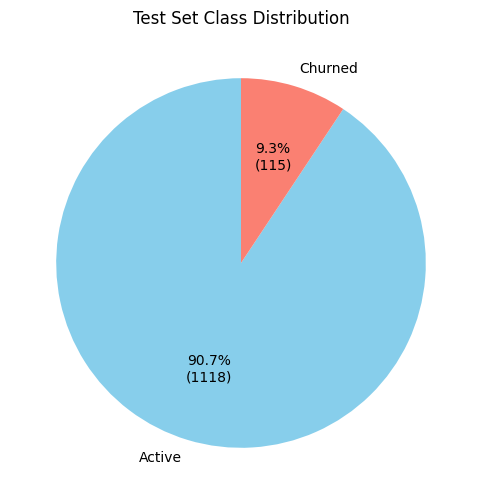

✅ Class distribution plotted
📊 Plotting confusion matrix...


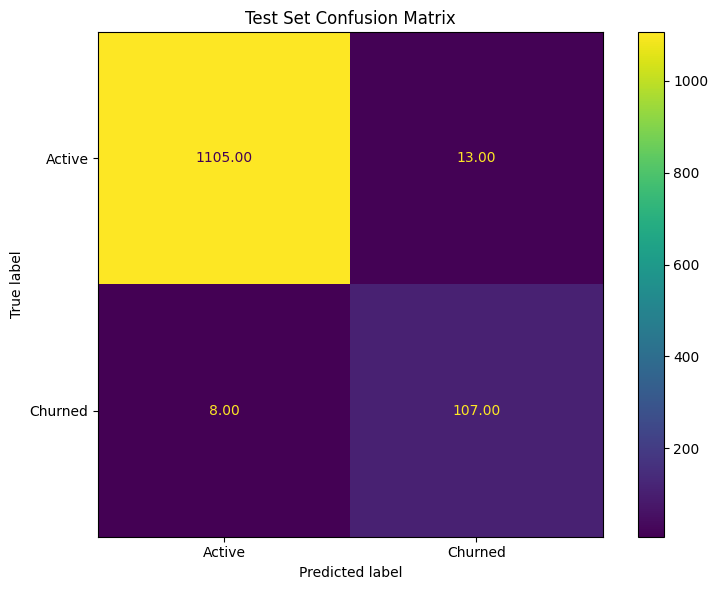

✅ Confusion matrix plotted
📊 Plotting ROC curve...


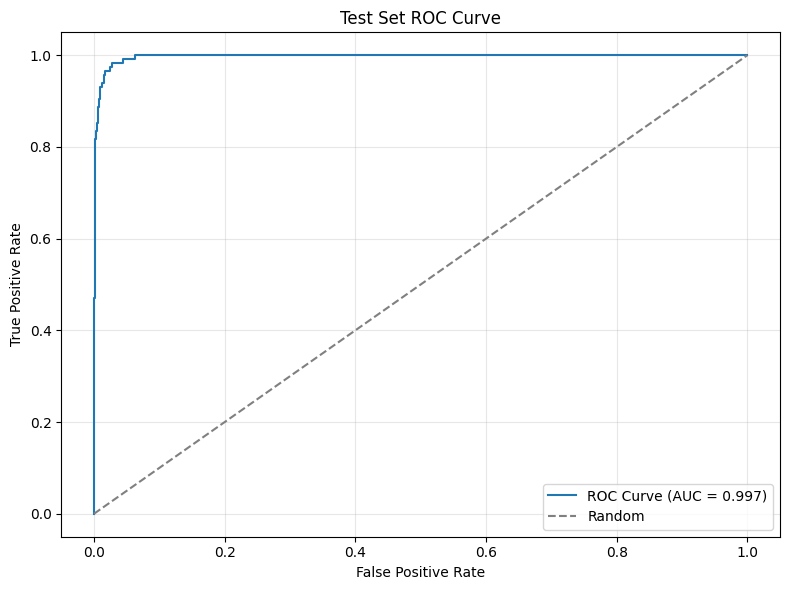

✅ ROC curve plotted
💾 Saving evaluation results to output/evaluation_results.csv...
✅ Evaluation results saved!

🎉 Model evaluation completed successfully!

Model Explanation [████████████████████████------] 80.0% (4/5)
   Generating SHAP explanations
🚀 Starting comprehensive model explanation...
🔍 Creating SHAP explainer...
✅ SHAP explainer created successfully!
🧮 Calculating SHAP values for 1233 samples...
✅ SHAP values calculated successfully!
📋 Creating explanations DataFrame...


1233it [00:00, 2409.69it/s]


✅ Explanations DataFrame created
💾 Saving explanations to output/shap_explanations.csv...
✅ Explanations saved successfully!

📊 Generating explanation plots...
📊 Plotting global feature importance (top 20)...


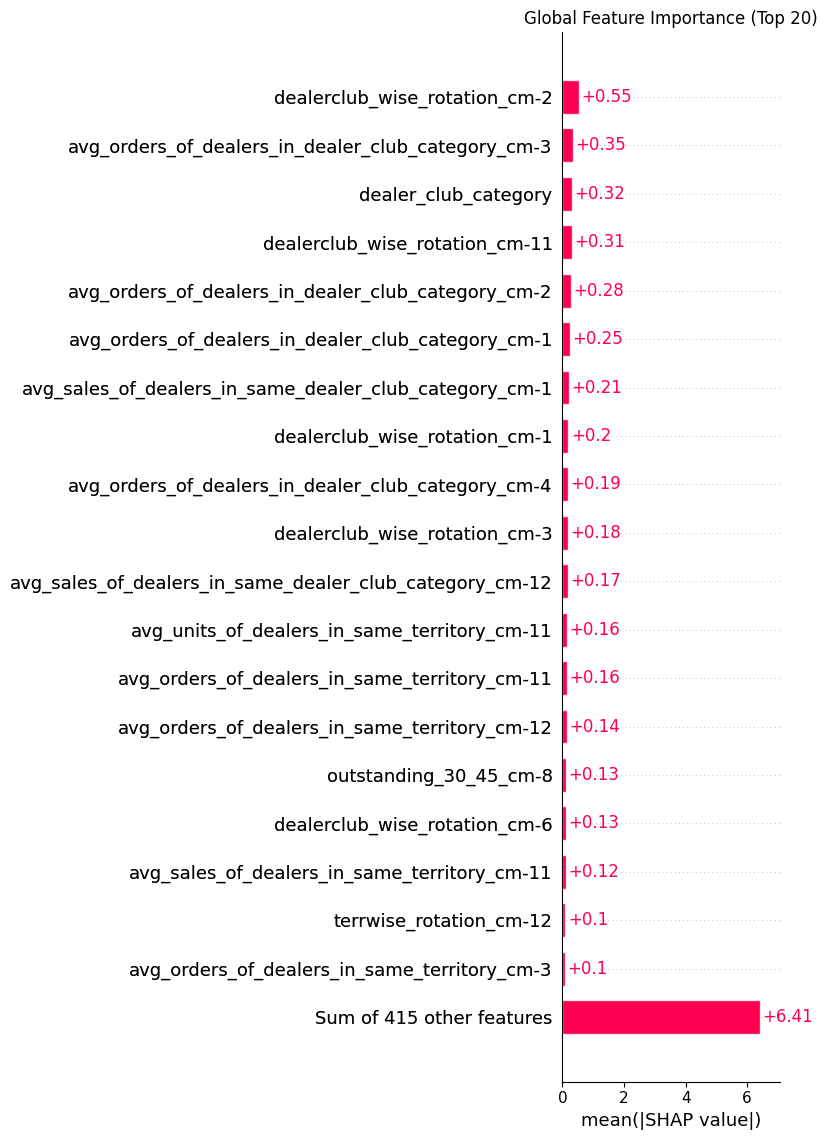

✅ Global importance plot created
📊 Plotting SHAP summary plot (top 20)...


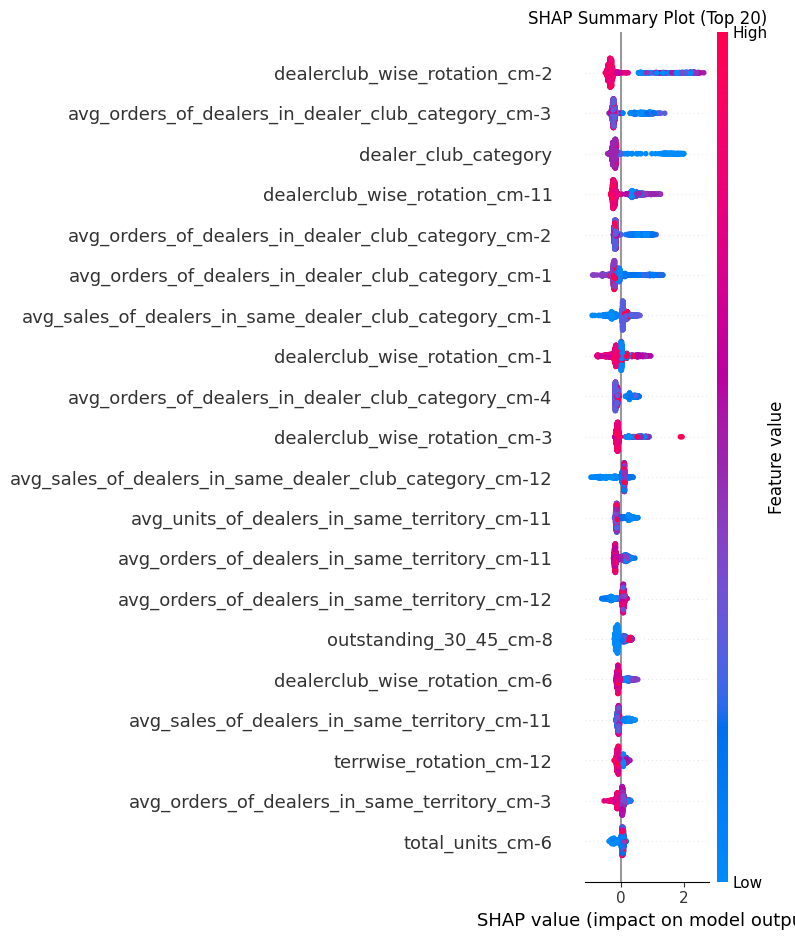

✅ Summary plot created
🔍 Explaining individual prediction for index 0...


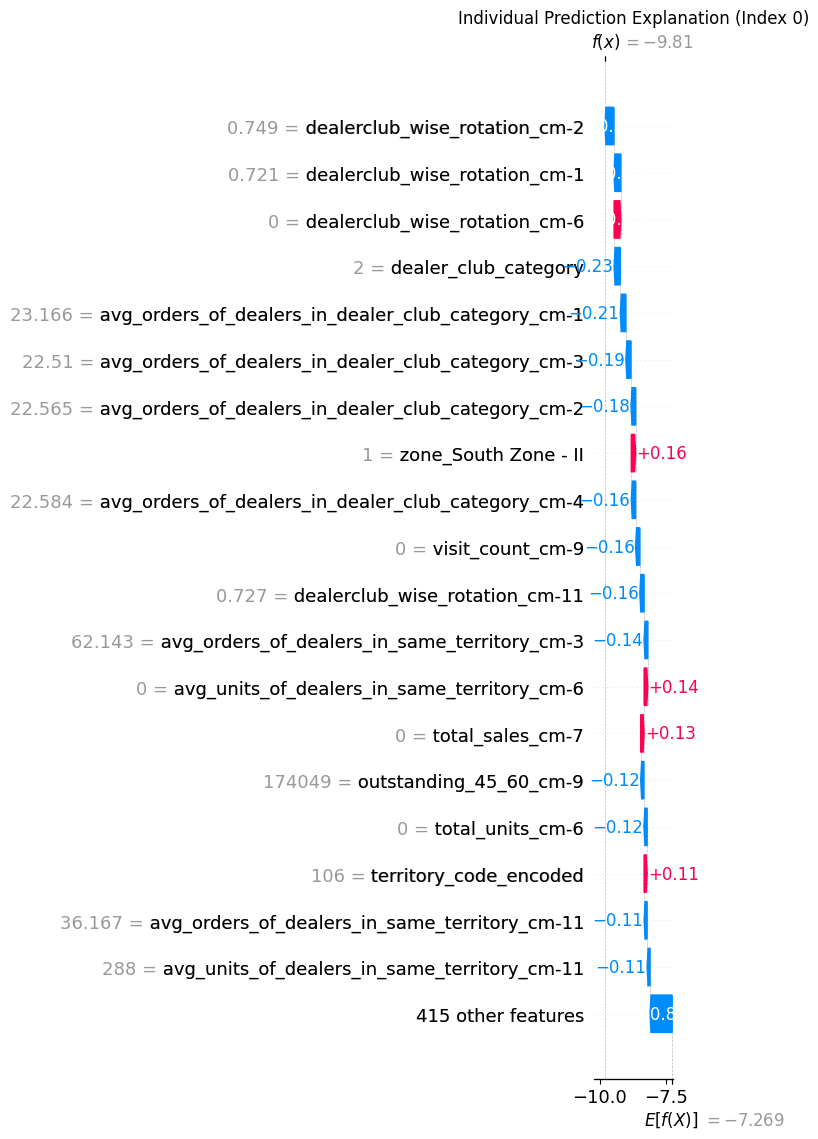

✅ Individual explanation created
🔍 Explaining individual prediction for index 1...


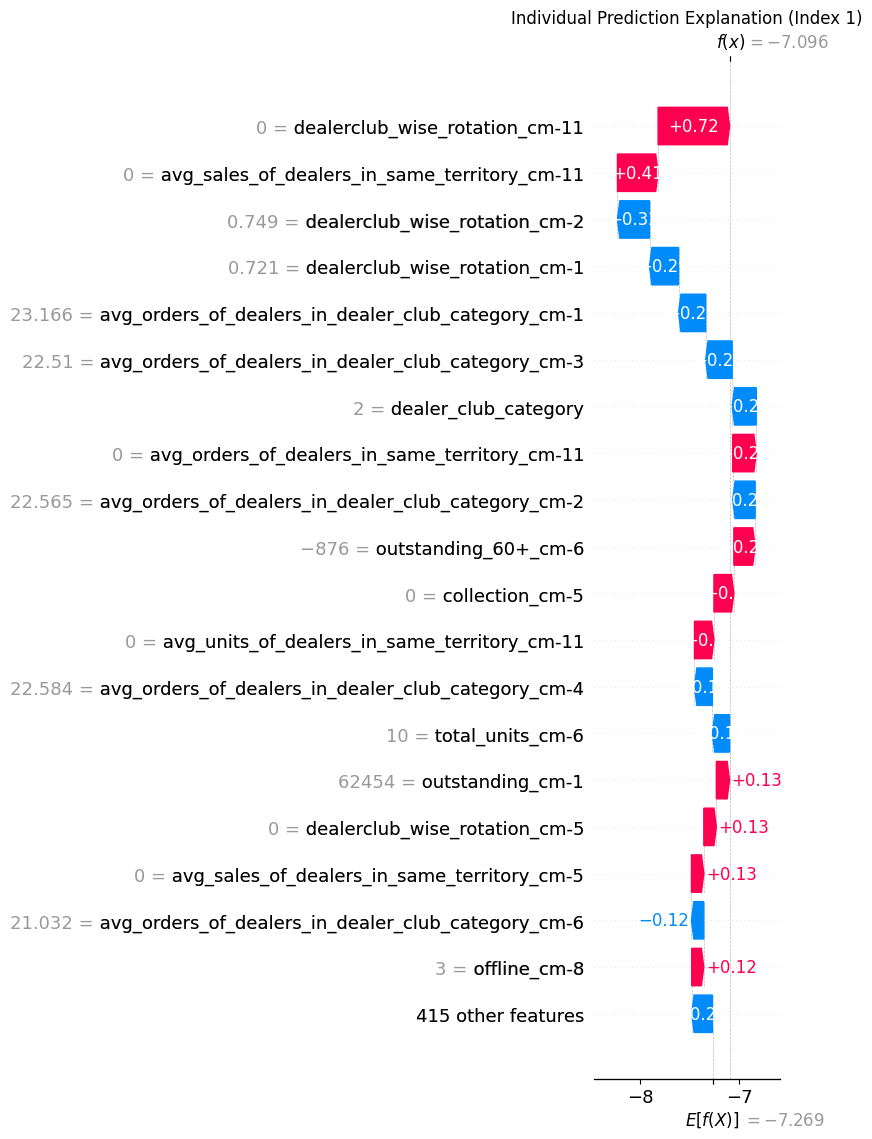

✅ Individual explanation created
🔍 Explaining individual prediction for index 2...


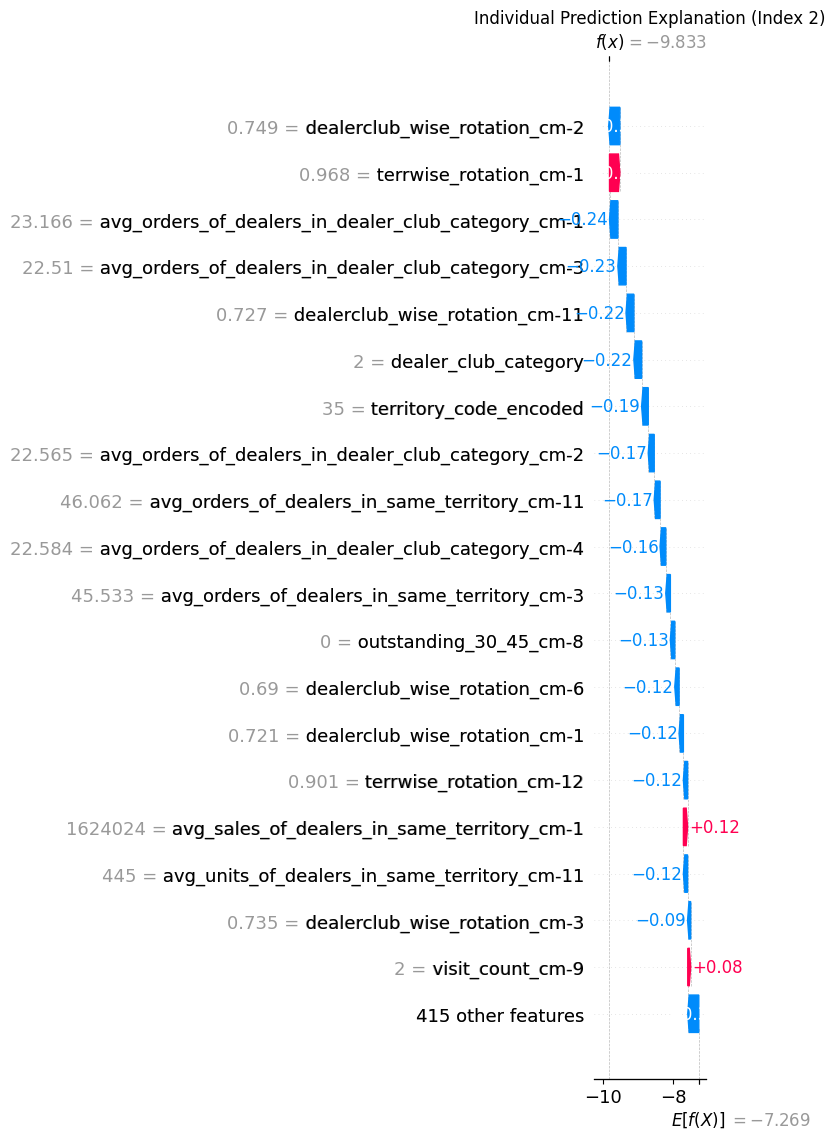

✅ Individual explanation created
🔍 Analyzing top 10 churn drivers...
✅ Top 10 churn drivers identified

🎉 Model explanation completed successfully!

Pipeline Setup [██████████████████████████████] 100.0% (5/5)
   Setting up production predictor
💾 Saving model to models/xgb_churn_model.pkl...
💾 Saving preprocessor info to models/xgb_churn_model_preprocessor_info.pkl...
✅ Preprocessor info saved!
✅ Model saved successfully!
📂 Loading model from models/xgb_churn_model.pkl...
✅ Model loaded successfully!
✅ Preprocessor info loaded from file
✅ Preprocessor info loaded

🎉 Complete training pipeline finished successfully!
Model saved to: models/xgb_churn_model.pkl
Feature importance saved to: models/feature_importance.csv


In [ ]:
results = model_pipeline.run_complete_training_pipeline(data_path="offset_features")

In [17]:
results["explanation_results"].keys()

dict_keys(['explanations_df', 'churn_drivers', 'explainer', 'shap_values'])

In [24]:
results["explanation_results"]["churn_drivers"].values

array([[2.07000000e+02, 1.67243722e+00, 2.63340700e+00, 3.46194504e+02],
       [2.96000000e+02, 7.31391644e-01, 1.39596321e+00, 2.16491927e+02],
       [4.18000000e+02, 5.04326888e-01, 1.26631127e+00, 2.10808639e+02],
       [2.80000000e+02, 6.38081750e-01, 1.12665814e+00, 1.78662890e+02],
       [1.24000000e+02, 1.34421650e+00, 2.00581911e+00, 1.66682846e+02],
       [2.36000000e+02, 5.74932049e-01, 1.33918959e+00, 1.35683963e+02],
       [8.07000000e+02, 1.51925331e-01, 6.14505842e-01, 1.22603742e+02],
       [2.13000000e+02, 5.54888107e-01, 1.94549130e+00, 1.18191167e+02],
       [3.01000000e+02, 3.65694285e-01, 5.89149854e-01, 1.10073980e+02],
       [5.54000000e+02, 1.88153193e-01, 9.58269537e-01, 1.04236869e+02]])

In [23]:
results["explanation_results"]["shap_values"].values

array([[-0.01491729,  0.        ,  0.        , ...,  0.        ,
        -0.00695238,  0.11475665],
       [ 0.0441549 ,  0.        ,  0.        , ...,  0.        ,
        -0.00671655,  0.03532468],
       [-0.0483409 ,  0.        ,  0.        , ...,  0.        ,
        -0.00435859, -0.18768376],
       ...,
       [-0.05149132,  0.        ,  0.        , ...,  0.        ,
        -0.00407111,  0.115509  ],
       [ 0.04882937,  0.        ,  0.        , ...,  0.        ,
        -0.0054183 ,  0.02811903],
       [ 0.18329238,  0.        ,  0.        , ...,  0.        ,
        -0.00396011, -0.02467229]])

In [18]:
results["explanation_results"]["explanations_df"]

,predicted_churn,positive_features,negative_features,top_features,total_positive_impact,total_negative_impact,net_impact
dealer_code,,,,,,,
1117307,0,{'dealerclub_wise_rotation_cm-6': 0.2554510486...,{'dealerclub_wise_rotation_cm-2': -0.340753924...,{'dealerclub_wise_rotation_cm-2': 0.3407539247...,3.447243,-5.988307,-2.541064
1113194,0,{'dealerclub_wise_rotation_cm-11': 0.722005228...,{'dealerclub_wise_rotation_cm-2': -0.323695310...,{'dealerclub_wise_rotation_cm-11': 0.722005228...,5.533607,-5.361002,0.172605
1119047,0,{'terrwise_rotation_cm-1': 0.29480925903189925...,{'dealerclub_wise_rotation_cm-2': -0.317668838...,{'dealerclub_wise_rotation_cm-2': 0.3176688388...,2.514703,-5.078634,-2.563931
1121980,0,{'avg_sales_of_dealers_in_same_territory_cm-1'...,{'dealerclub_wise_rotation_cm-2': -0.271992211...,{'dealerclub_wise_rotation_cm-2': 0.2719922114...,2.523194,-5.820749,-3.297555
1120576,0,"{'collection_cm-1': 0.2429543969919905, 'deale...",{'dealerclub_wise_rotation_cm-2': -0.313846188...,{'dealerclub_wise_rotation_cm-2': 0.3138461886...,3.798120,-5.965992,-2.167873
...,...,...,...,...,...,...,...
1114736,0,{'avg_sales_of_dealers_in_same_dealer_club_cat...,{'dealerclub_wise_rotation_cm-2': -0.372695292...,{'dealerclub_wise_rotation_cm-2': 0.3726952922...,2.308310,-4.922724,-2.614414
1116093,0,"{'outstanding_30_45_cm-8': 0.2992049718275666,...",{'dealerclub_wise_rotation_cm-2': -0.300681755...,{'dealerclub_wise_rotation_cm-2': 0.3006817550...,3.698776,-4.061497,-0.362720
1122137,0,{'terrwise_rotation_cm-1': 0.34923782327212394...,{'dealerclub_wise_rotation_cm-2': -0.293604909...,{'terrwise_rotation_cm-1': 0.34923782327212394...,2.402939,-5.631714,-3.228774


In [25]:
prediction_results = model_pipeline.run_production_prediction_pipeline(data_path="offset_features")

🚀 Starting Production Prediction Pipeline
📂 Loading model from models/xgb_churn_model.pkl...
✅ Model loaded successfully!
✅ Preprocessor info loaded from file
🚀 Starting prediction for all dealers...
📊 Loading data from offset_features...
⚡ Initializing Databricks Spark session...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📄 Setting schema to: `data_science`
📊 Loading data from DLT table: offset_features...
📖 Reading table: `offset_features`...
✅ Successfully read data from `offset_features`.
🔍 Found dtype file: offset_features_dtypes.json
✅ Data types loaded from: offset_features_dtypes.json
   Columns: 397
   Shape: [7717, 397]
✅ Data types restored for 397 columns
✅ Data types restored from offset_features_dtypes.json
✅ Data loaded successfully. Shape: (7717, 396)
📊 Data types summary:
   - Object columns: 6
   - Numeric columns: 390
🔧 Preparing data for production prediction...
📊 Applying preprocessing steps...
✅ Data prepared. Shape: (6161

In [26]:
prediction_results

,dealer_code,predicted_churn,churn_probability,prediction_label,risk_category,prediction_timestamp
0,1100001,0,0.00000,Active,Low Risk,2025-09-08 15:34:22
1,1100011,0,0.00026,Active,Low Risk,2025-09-08 15:34:22
2,1100014,1,0.99969,Churned,High Risk,2025-09-08 15:34:22
3,1100015,0,0.00000,Active,Low Risk,2025-09-08 15:34:22
4,1100030,0,0.00025,Active,Low Risk,2025-09-08 15:34:22
...,...,...,...,...,...,...
6156,1123159,0,0.00058,Active,Low Risk,2025-09-08 15:34:22
6157,1123160,0,0.00033,Active,Low Risk,2025-09-08 15:34:22
6158,1123161,0,0.00316,Active,Low Risk,2025-09-08 15:34:22
6159,1123162,0,0.00430,Active,Low Risk,2025-09-08 15:34:22


In [27]:
from dlt_utils import DLTWriter

dlt_writer = DLTWriter(catalog="provisioned-tableau-data", schema="data_science")
file_path = "dealer_churn_predictions"
dlt_writer.write_table(prediction_results, file_path, mode="overwrite")


⚡ Initializing Databricks Spark session for writing...
✅ Session initialized successfully.
📁 Setting catalog to: `provisioned-tableau-data`
📝 Writing DataFrame to table: `dealer_churn_predictions`...
   Mode: overwrite
   Partition by: None
   Merge schema: True
🔄 Converting Pandas DataFrame to Spark DataFrame...
📄 Setting schema to: `data_science`
✅ Successfully wrote data to `dealer_churn_predictions`.


True

In [ ]:
# import pandas as pd
# pd.set_option('display.max_columns', None)

In [ ]:
# df_prod = pd.read_csv('offset_features.csv')
# df_ref = pd.read_csv('_offset_features.csv')
